In [126]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pyuvdata
import pyuvsim
import uvtools

## Convert beam file to .txt that can be parsed by UVBeam

In [91]:
DIR='001SweepAntennaAngle'
FNAME_BASE='RadiatedElectricField_Freq10MHz_AntennaLength6m_AntennaAngle30deg_LanderHeight2m_in_phase'
FREQ=10*1e6  # Hz

In [92]:
def rev_indices(arr, ph, th):
    """
    Convert from phi changing fastest to theta changing fastest (Fortran style to C style)
    """
    return arr.copy().reshape(np.unique(ph).size, np.unique(th).size, order='F').flatten(order='C')

def to_txt(dirpath, fname_base):
    components=['rEX', 'rEY', 'rEZ']
    # load phi and theta
    phi,theta=np.loadtxt(
        os.path.join('../data/AntennaSimResults', dirpath, fname_base+'_re('+components[0]+').csv'),
        skiprows=1,
        delimiter=',',
        usecols=(0,1)
    ).T
    data_len=phi.size
    E_field_mag=np.empty((len(components), data_len))  # magnitude squared of e field components
    for i, component in enumerate(components):
        re_path=os.path.join('../data/AntennaSimResults', dirpath, fname_base+'_re('+component+').csv')
        im_path=os.path.join('../data/AntennaSimResults', dirpath, fname_base+'_im('+component+').csv')
        real_part=np.loadtxt(re_path, skiprows=1, delimiter=',', usecols=2)
        im_part=np.loadtxt(im_path, skiprows=1, delimiter=',', usecols=2)
        E_mag=real_part**2+im_part**2 
        E_field_mag[i]=E_mag
        
    volt_beam=np.sqrt(E_field_mag.sum(axis=0)) # sum over x,y,z-components
    volt_beam/=1e3  # mV to V
    
    data=np.empty((data_len, 3))
    data[:,0]=rev_indices(theta, phi, theta)
    data[:,1]=rev_indices(phi, phi, theta)
    data[:,2]=rev_indices(volt_beam, phi, theta)
    
    outpath=os.path.join('../data/txt_beams', dirpath, fname_base+'.txt')
    if not dirpath in os.listdir('../data/txt_beams'):
        print(f'{dirpath} not found, making dir')
        os.makedirs(os.path.join('../data/txt_beams', dirpath))
    np.savetxt(outpath, data, header='Theta [deg.] Phi [deg.] Abs(V) [V] \n\n', comments='')
    
    return outpath

In [93]:
fname=to_txt(DIR, FNAME_BASE)

## Initialize UVBeam object

In [94]:
uvb=pyuvdata.uvbeam.UVBeam()
uvb.read_cst_beam(filename=fname, beam_type="power", feed_pol="x", rotate_pol=False,
                  frequency=FREQ, telescope_name='lusee-night', feed_name='monopole', feed_version='1.0',
                  model_name='in-phase', model_version='1.0', history="", x_orientation='north',
                  reference_impedance=50)

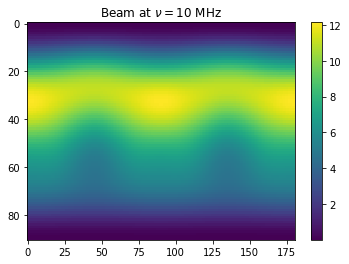

In [127]:
# beam vs phi and theta (data coordinates, extent is [pi/2, 3pi/2, 0, pi])
plt.figure()
uvtools.plot.waterfall(uvb.data_array[0,0,0,0], mode='real')
plt.title('Beam at $\\nu=10$ MHz')
plt.colorbar()
plt.show()

In [130]:
beampath=os.path.join('../data/uvbeams', DIR, FNAME_BASE+'.uvbeam')
uvb.write_beamfits(beampath)

In [95]:
# uvb=pyuvdata.uvbeam.UVBeam()
# uvb.Naxes_vec=3
# uvb.Nfreqs=1
# uvb.Nspws=1  # only supported value
# uvb.antenna_type='simple'
# uvb.bandpass_array=np.zeros((uvb.Nspws, uvb.Nfreqs)) # ?
# uvb.beam_type='efield'
# # feed_pol='xx'
# # rot_pol_dict = {"xx": "yy", "yy": "xx", "xy": "yx", "yx": "xy"}
# # pol2 = rot_pol_dict[feed_pol]
# # uvb.polarization_array = np.array([utils.polstr2num(feed_pol), utils.polstr2num(pol2)])
# # uvb.Npols = len(uvb.polarization_array)
# uvb.Npols=1
# uvb.Naxes2=np.unique(theta).size
# uvb.Naxes1=np.unique(phi).size
#  # shape = Naxes_vec, Nspws, Nfeeds or Npols, Nfreqs, Naxes2, Naxes1
# uvb.data_array=np.empty((uvb.Naxes_vec,uvb.Nspws,uvb.Npols,uvb.Nfreqs,uvb.Naxes2,uvb.Naxes1), dtype=np.complex64)
# for i in range(3):
#     uvb.data_array[i, 0, 0, 0, :, :]=E_field[i].T.copy()
# uvb.data_normalization='physical'
# uvb.feed_name='lusee'
# uvb.feed_version='v1.0'
# uvb.freq_array=np.expand_dims(np.unique(freq)*1e9, axis=0)
# uvb.history=''
# uvb.model_name='inphase_25cm'
# uvb.model_version='v1.0'
# uvb.pixel_coordinate_system='az_za'
# uvb.spw_array=np.array([0])
# uvb.telescope_name='lusee-night'

In [57]:
E_field.shape

(3, 181, 91)

In [56]:
uvb.data_array.shape

(3, 1, 1, 1, 91, 181)

In [120]:
for i, f in enumerate(np.unique(freq)):
    freq_indices=np.argwhere(freq==f)[:,0]
    uvb.data_array[0,0,0,i,:,:]=gain[freq_indices].reshape(
        (np.unique(theta).size, np.unique(phi).size), order='F'
    )

In [129]:
freq[0]*1e2

2.0